## SMS Message Spam Detection

### Introduction

The data I will be using for this analysis project consists of tagged messages that have been collected for SMS spam research originally by researchers at UC Irvine. The dataset contains 5574 english SMS messages, which I will attempt to classify as spam or not spam by first cleaning, processing, and eventually modeling with various classification methods. This project is mainly for improving my understanding of preprocessing methods for text data (tokens, vectorizers, etc.) in addition to some classification techniques commonly used when working with NLP problems (Naive Bayes and KNN).

More detailed information on the dataset including how the dataset was assembled can be found here: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection. 

Reference:

Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.


http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

import nltk

### Basic Data Cleaning and Pre-Processing

In [2]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# Drop unnecessary columns, rename columns
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
data = data.rename(columns={"v1":"label", "v2":"text"})

# Change the label column's values to better reflect the label itself ('ham' = 'not spam')
data['label'] = data['label'].map({'ham':'not spam', 'spam':'spam'})
data['spam'] = data['label'].map({'not spam':'0', 'spam':'1'})

# Add a column that counts the number of characters in each text
data['length'] = data['text'].apply(len)

data.head()

,label,text,spam,length
0,not spam,"Go until jurong point, crazy.. Available only ...",0,111
1,not spam,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,not spam,U dun say so early hor... U c already then say...,0,49
4,not spam,"Nah I don't think he goes to usf, he lives aro...",0,61


Just in case, let's check for missing values:

In [4]:
data.isnull().sum()

label     0
text      0
spam      0
length    0
dtype: int64

A large part of what would be considered "data cleaning" with regards to this data set (removing punctuation, fixing errors in language, etc.) actually constitutes a lot of the processing that we're going to do later on. Let's do a preliminary EDA first.

### Preliminary EDA

We can start by seeing how many of each message type we have:

In [5]:
spam_dist = data['label'].value_counts()
spam_dist

not spam    4825
spam         747
Name: label, dtype: int64

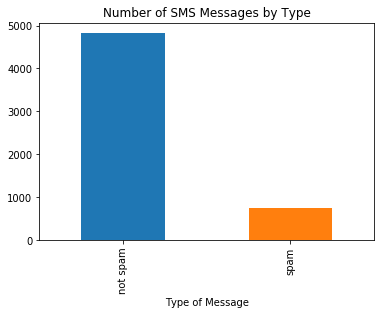

In [6]:
spam_dist.plot(kind='bar')
plt.title('Number of SMS Messages by Type')
plt.xlabel('Type of Message')

plt.savefig('Figures\\Number of Messages by Type.pdf');

We essentially have way more messages that aren't spam in our dataset than those that are. It'd also be interesting to see the typical message length of each type:

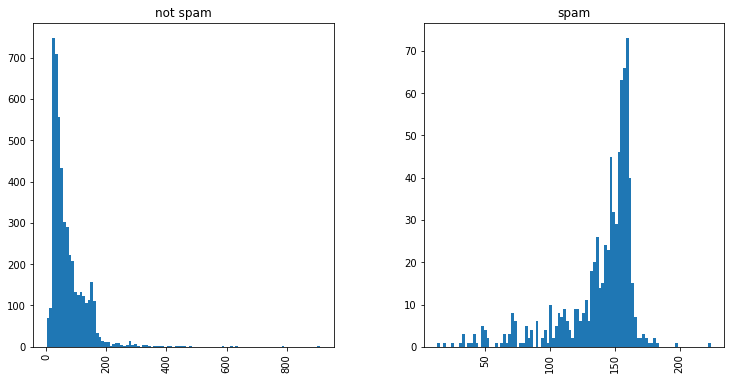

In [7]:
data.hist(column='length',by='label',bins=100,figsize=(12,6))
plt.savefig('Figures\\Length of Messages by Type.pdf');

In [8]:
data.groupby('label').describe()

length                                                         
           count        mean        std   min    25%    50%    75%    max
label                                                                    
not spam  4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam       747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0

It seems that spam messages are typically longer than messages that aren't spam! Let's generate wordclouds to better understand the words that are commonly appear in each type of message.

In [9]:
# Create subsets of the data by label
spam_messages = data[data['label'] == 'spam']
not_spam_messages = data[data['label'] == 'not spam']

In [10]:
import wordcloud

def gen_wordcloud(data, title):
    all_text = ' '.join(data['text'].tolist())
    wordcloud_obj = wordcloud.WordCloud(background_color='white', 
                    max_words= 50, width=800, height=600).generate(all_text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(wordcloud_obj, interpolation='bilinear')  
    plt.axis('off')
    plt.title(title, fontsize=15)
    plt.savefig('Figures\\{}.pdf'.format(title))
    plt.show()

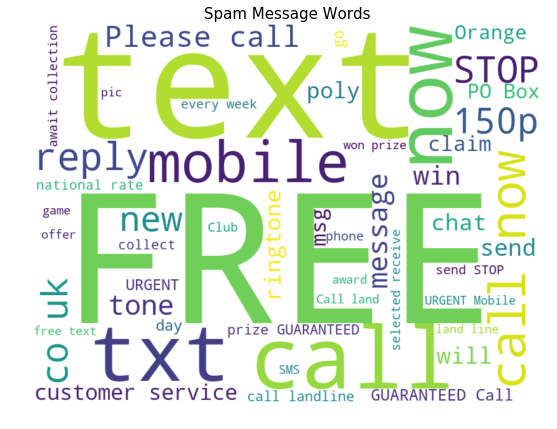

In [11]:
gen_wordcloud(spam_messages, 'Spam Message Words')

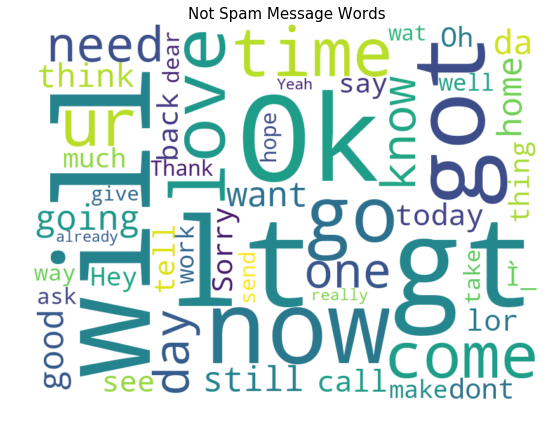

In [12]:
gen_wordcloud(not_spam_messages, 'Not Spam Message Words')

Let's remove stopwords and punctuation from the messages so that we can get closer to what we want for modeling later:

In [13]:
import string
from nltk.corpus import stopwords

def clean_text(text):
    no_punctuation = text.translate(str.maketrans('','', string.punctuation))
    word_list = no_punctuation.lower().split()
    
    return [word for word in word_list if word not in stopwords.words('english')]

To ensure that this function works as intended:

In [14]:
data['cleaned_text'] = data['text'].apply(clean_text)
data['cleaned_text'].head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: cleaned_text, dtype: object

It also might be a fun exercise to see how the length of each type of message changes when we remove these things:

In [15]:
def cleaned_length(text):
    temp = ' '.join(text)
    return len(temp)

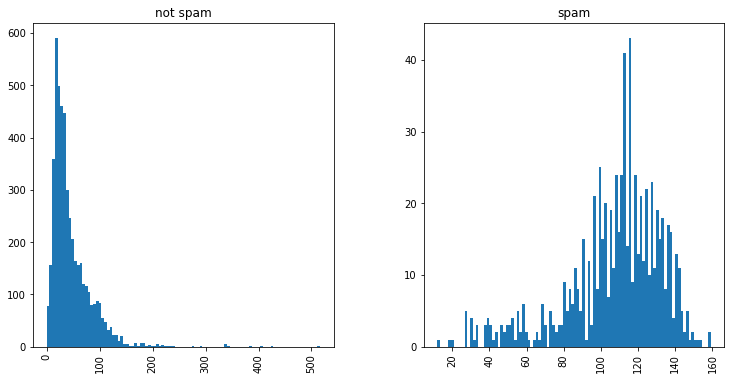

In [16]:
data['cleaned_length'] = data['cleaned_text'].apply(cleaned_length)
data.hist(column='cleaned_length',by='label',bins=100,figsize=(12,6))
plt.savefig('Figures\\Length of Messages by Type, No Stopwords or Punctuation.pdf');

In [17]:
data.groupby('label').describe()['cleaned_length']

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
not spam,4825.0,45.655959,38.018317,0.0,21.0,34.0,60.0,516.0
spam,747.0,107.368139,25.989938,12.0,97.0,112.0,125.0,159.0


It's interesting to see that messages that weren't spam were essentially halved by removing stopwords and punctuation. The length of spam messages were reduced by around the same amount of characters.

Now let's take a more specific look at the most frequently occuring words in each type of message:

In [18]:
spam_messages = data[data['label'] == 'spam']
not_spam_messages = data[data['label'] == 'not spam']

In [19]:
def get_LoW(column):
    LoW = []
    for entry in column:
        for word in entry:
            LoW.append(word)
            
    return LoW

In [20]:
# Split the data according to type
LoW_spam = get_LoW(spam_messages['cleaned_text'])
LoW_not_spam = get_LoW(not_spam_messages['cleaned_text'])

# Use nltk's freqdist to obtain word counts
freqdist_spam = nltk.FreqDist(LoW_spam)
freqdist_not_spam = nltk.FreqDist(LoW_not_spam)

# Create DataFrames
top25_spam_words_df = pd.DataFrame(freqdist_spam.most_common(25), columns=['Word', 'Frequency'])
top25_not_spam_words_df = pd.DataFrame(freqdist_not_spam.most_common(25), columns=['Word', 'Frequency'])

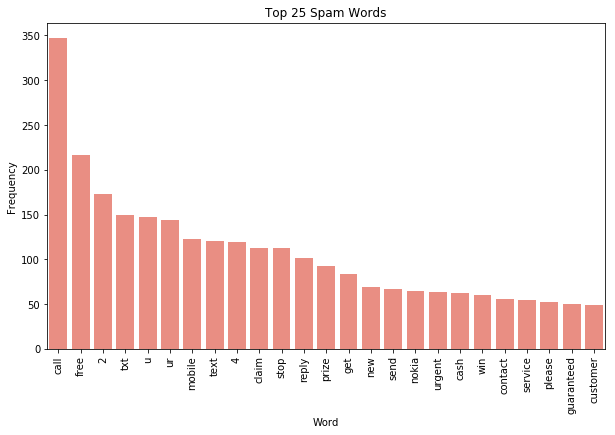

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Word', y='Frequency', data=top25_spam_words_df, color='salmon') 
plt.title('Top 25 Spam Words')
plt.xticks(rotation='vertical')

plt.savefig('Figures\\Top 25 Spam Words.pdf');

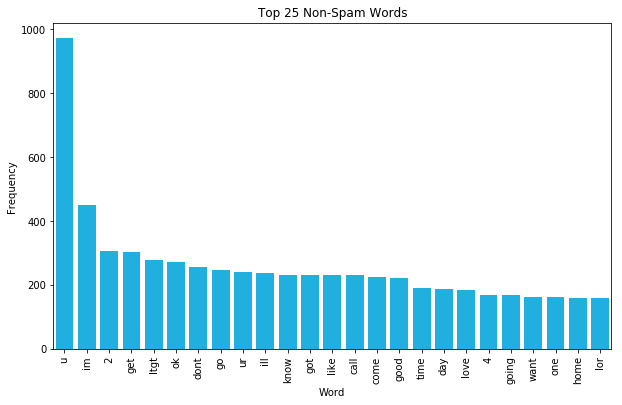

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Word', y='Frequency', data=top25_not_spam_words_df, color='deepskyblue') 
plt.title('Top 25 Non-Spam Words')
plt.xticks(rotation='vertical')

plt.savefig('Figures\\Top 25 Non-Spam Words.pdf');

### Bag of Words Model

With the idea that we need to represent our text data in a "numerical" way in mind, we can use the bag of words model. The bag of words model works essentially by representing text as a multiset (bag) of the multiplicity of its words ignoring the grammar and word order. It works, in our case, as follows:
* First, we tokenize strings (assigning each token an integer id) - each individual token frequency is considered a "feature". 
* Then we vectorize each sms message by counting the occurrences of tokens. 
* Finally, we use a matrix with one row per message and one column per token.

For our purposes, we will use `CountVectorizer` which we can use to encode words and generate a vocabulary, then apply it in order to obtain word counts.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
# Here we pass in clean_text as a callable that is used to extract the sequence of features out of the raw input
bow_transformer = CountVectorizer(analyzer = clean_text).fit(data['text'])
print(len(bow_transformer.vocabulary_))

9431


The vocabulary of all of the sms messages in our dataset consists of 9431 unique words. Let's take a look at an example of a vectorized message before we apply it to our entire dataset. This:

In [25]:
example = data['text'][50]
example

'What you thinked about me. First time you saw me in class.'

Is transformed into this:

In [26]:
bow_example = bow_transformer.transform([example])
print(bow_example)

  (0, 2192)	1
  (0, 3413)	1
  (0, 7128)	1
  (0, 8225)	1
  (0, 8284)	1


Where the first number in the tuple represents the row or the message, and the second represents the integer id assigned to the word (each token). The number at the very right in each line represents its count in the sentence. We can see that the number of words in this mini bag of words model is less than the number of words in the actual message due to stopwords like "in" being removed. Let's now apply this to our dataset:

In [27]:
bow = bow_transformer.transform(data['text'])
bow.shape

(5572, 9431)

Because most messages will contain a very, very small subset of all the words in the vocabulary, many of the entries in the matrix will be zero. We need calculate the sparsity (or percentage of non-zero entries) in the matrix in order to make sure we're actually doing something here.

In [28]:
# Number of non-zero elements in matrix
bow.nnz

49772

In [29]:
bow.nnz / (bow.shape[0] * bow.shape[1]) * 100

0.09471444959776236

Around 9.5% of the matrix entries are non-zero

### Term Frequency-Inverse Document Frequency (TF-IDF)

While word occurrence count is a good start, we probably want to account for things like document length (which will have higher count values) when thinking about word importance. 

A good way to build on what we have is through TF-IDF, which is a statistical measure used to evaluate word importance.

A quick summary of how TF and IDF are defined in consideration of a term t:
* Term Frequency (TF) is calculated by dividing the number of times a term t appears in the dataset divided by the total number of terms
* Inverse Document Frequency (IDF) is the natural log of the total number of messages divided by the number of messages with the term t in it.
* TF-IDF is the product of TF and IDF

To consolidate: TF-IDF increases proportionally to the number of times the word appears in our dataset, but is offset by the frequency of the word in the dataset as well.

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer

# Fit the tranfsformer first to the bag of words data
tfidf_transformer = TfidfTransformer().fit(bow)

Let's take a look at an example of how this works:

In [31]:
tfidf_example = tfidf_transformer.transform(bow_example)
print(tfidf_example)

  (0, 8284)	0.3028179275329587
  (0, 8225)	0.6236270966154333
  (0, 7128)	0.4501428647422092
  (0, 3413)	0.38617185246884916
  (0, 2192)	0.4094303955669429


Same interpretation as in the bag of words transformed example, but we can see the TF-IDF scores instead of the counts. Let's apply the transformation to the entire bag of words dataset.

In [32]:
tfidf = tfidf_transformer.transform(bow)

### Classification Methods

First let's split up our data into training and testing sets. I'd like to vary the sets of features so we can see the effect of including them on our prediction accuracy.

In [33]:
from sklearn.model_selection import train_test_split

# Just the TF-IDF Matrix
tfidf_train, tfidf_test, label_train, label_test = \
train_test_split(tfidf, data['spam'], test_size=0.3, random_state=42)

tfidf_train = tfidf_train.A
tfidf_test = tfidf_test.A

In [34]:
# Need to import hstack from scipy.sparse to combine sparse matrices
from scipy.sparse import hstack

# The TF-IDF Matrix and the length of each message
tfidf_all = hstack((tfidf, np.array(data['length'])[:, None])).A

tfidf_all_train, tfidf_all_test, tfidf_all_label_train, tfidf_all_label_test = \
train_test_split(tfidf_all, data['spam'], test_size=0.3, random_state=42)

#### Naive Bayes 

Because we are working with discrete counts, we need to use Multinomial Naive Bayes, which conveniently, is something we can easily implement through sciki-learn. We use Naive Bayes to ascertain the probability that an SMS message is spam given its feature vector containing word frequencies. The "naive" assumption that we're making here is that the word frequencies that we're observing are independent of one another.

First let's use only the TF-IDF matrix in our model:

In [35]:
from sklearn.naive_bayes import MultinomialNB

spam_classifier = MultinomialNB().fit(tfidf_train, label_train)
preds_tfidf = spam_classifier.predict(tfidf_test)
MNB_score = accuracy_score(label_test, preds_tfidf)
MNB_score

0.9575358851674641

We can see that our model is already performing relatively well, correctly classifying close to 96% of message in our dataset.

Now let's try using the TF-IDF matrix in addition to the length feature:

In [36]:
spam_classifier_all = MultinomialNB().fit(tfidf_all_train, tfidf_all_label_train)
preds_tfidf_all = spam_classifier_all.predict(tfidf_all_test)
MNB_score_all = accuracy_score(tfidf_all_label_test, preds_tfidf_all)
MNB_score_all

0.8690191387559809

This set of features performs much worse than our initial model - most likely due to the features not being scaled properly.

Let's now scale the features properly before we model. We use `MinMaxScaler` due to the fact that our data is not normally distributed and the standard deviation is likely to be small (as we are working with decimal frequencies).

In [37]:
# Obtain the tfidf matrix as well as the length feature, scale both
tfidf_train_feat = tfidf_all_train[:, :9431]
tfidf_test_feat = tfidf_all_test[:, :9431]

tfidf_len_train = tfidf_all_train[:, 9431]
tfidf_len_test = tfidf_all_test[:, 9431]

from sklearn.preprocessing import MinMaxScaler

MMScaler = MinMaxScaler()
tfidf_train_scaled = MMScaler.fit_transform(tfidf_train_feat)
tfidf_test_scaled = MMScaler.transform(tfidf_test_feat)

MMScaler = MinMaxScaler()
tfidf_len_train_scaled = MMScaler.fit_transform(tfidf_len_train.reshape(-1, 1))
tfidf_len_test_scaled = MMScaler.transform(tfidf_len_test.reshape(-1, 1))

# Combine them back into one matrix
tfidf_train_full = np.hstack((tfidf_train_scaled, tfidf_len_train_scaled))
tfidf_test_full = np.hstack((tfidf_test_scaled, tfidf_len_test_scaled))

In [38]:
spam_classifier_all_scaled = MultinomialNB().fit(tfidf_train_full, tfidf_all_label_train)
preds_tfidf_all_scaled = spam_classifier_all_scaled.predict(tfidf_test_full)
MNB_score_all_scaled = accuracy_score(tfidf_all_label_test, preds_tfidf_all_scaled)
MNB_score_all_scaled

0.9760765550239234

We can see that now including the length feature in our model in addition to scaling the features yields the highest accuracy score. The accuracy score, however, while intuitive in measuring performance, doesn't really paint the full picture of our classification error. I'd like to better understand misclassification here through plotting confusion matrices for all of our results.

In [39]:
def plot_confusion_matrix(y_true, y_pred):
    con_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(con_matrix, annot=True, fmt='d', linewidths=1,  
                cmap="Blues", cbar=False)
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [40]:
list_feat_var = ['TF-IDF Matrix Only', 
                 'TF-IDF Matrix + Len Feature', 
                 'TF-IDF Matrix + Len Feature Scaled']

list_preds = [preds_tfidf, preds_tfidf_all, preds_tfidf_all_scaled]

preds_dict = dict(zip(list_feat_var, list_preds))

In [41]:
def plot_all_confusion_matrices(true_labels, predictions_dict, title, n, figsize):
    keys = list(predictions_dict.keys())
    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=15)

    for key in keys: 
        plt.subplot(n)
        plot_confusion_matrix(true_labels, predictions_dict[key])
        plt.title(key, y=1.02)
        n+=1
    
    plt.savefig('Figures\\{}.pdf'.format(title));

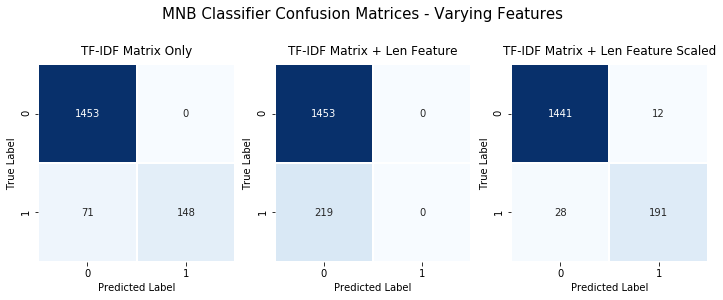

In [42]:
plot_all_confusion_matrices(label_test, preds_dict, "MNB Classifier Confusion Matrices - Varying Features", 231, (12,8))

When we take a look at the confusion matrices, we might come to the conclusion that accuracy score might not be the best metric by which we select the best set of features / transformation. When we include the length feature and scale all the features in our model, we get the highest accuracy score of around `0.976`. However, this set of features also results in 12 false positives, or not spam messages being classified as spam (we definitely want to avoid sending important messages to a spam box). Including just the TF-IDF matrix may yield a slightly lower accuracy score than the aforementioned set of features, but it classifies all non spam messages correctly.

#### K-Nearest Neighbors (KNN)

Another classification method we can apply here is K-Nearest Neighbors, or KNN. KNN essentially works by looking at the "neighbors" of each object (in this case a transformed vector representation of word frequency for each message), and classifying the object according to count, distance, etc.

In [43]:
# grid_params = {'n_neighbors': np.arange(10,21), 'weights': ['uniform', 'distance']}
# knn = KNeighborsClassifier()

# grid_knn = GridSearchCV(knn, grid_params, cv=5, n_jobs=-1, verbose=1)
# grid_knn.fit(tfidf_train, label_train)
# print(grid_knn.best_score_)
# print(grid_knn.best_param_)

I first used sklearn's GridSearch CV in order to tune the hyperparameters. For the dataset with unscaled data, I found that 18 neighbors yielded the top accuracy score of `0.93`. I also found that utizling the `uniform` rather than the `distance` weight (essentially checking counts of classes of neighbors rather than weighting them by distance) yielded better results. For the sake of rerunning my code without having to wait hours per run, I've implemented KNN without gridsearchcv, but have kept the code commented above.

In [44]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=18, n_jobs=-1)
knn.fit(tfidf_train, label_train)
knn_preds = knn.predict(tfidf_test)
knn_score = accuracy_score(label_test, knn_preds)

In [45]:
knn_score

0.9318181818181818

We can see that KNN does a bit worse than MNB (according to accuracy) for our unscaled data. Let's do the same for the scaled data:

In [46]:
# grid_params = {'n_neighbors': np.arange(3, 15), 'weights': ['uniform', 'distance']}
# knn = KNeighborsClassifier()

# grid_knn = GridSearchCV(knn, grid_params, cv=5, n_jobs=-1, verbose=1)
# grid_knn.fit(tfidf_train_scaled, label_train)
# print(grid_knn.best_score_)
# print(grid_knn.best_param_)

For the dataset with scaled data, I found that the number of neighbors between 5-16 yielded the top accuracy score of `0.95`. I also found, again, that utizling the `uniform` rather than the `distance` weight yielded better results. I've commented out the code as in the previous case, which I've kept above for reference.

In [47]:
knn2 = KNeighborsClassifier(n_neighbors=15, n_jobs=-1)
knn2.fit(tfidf_train_scaled, label_train)
knn_scaled_preds = knn.predict(tfidf_test_scaled)
knn_scaled_score = accuracy_score(label_test, knn_scaled_preds)

In [48]:
knn_scaled_score

0.9509569377990431

Our scaled dataset did a bit better than our unscaled data - in the ballpark of some of the best results we got with MNB. Let's plot confusion matrices again to better understand the nature of our misclassification.

In [49]:
list_feat_var = ['Unscaled TF-IDF Matrix',  'TF-IDF Matrix Scaled']

list_preds = [knn_preds, knn_scaled_preds]

preds_dict = dict(zip(list_feat_var, list_preds))

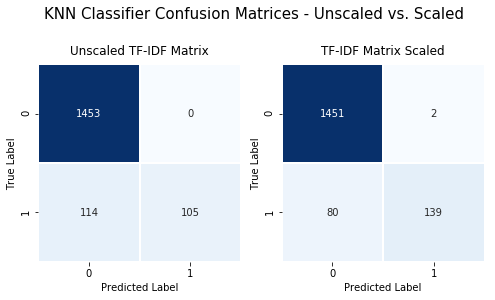

In [50]:
plot_all_confusion_matrices(label_test, preds_dict, "KNN Classifier Confusion Matrices - Unscaled vs. Scaled", 221, (8, 8))

In general, we can see that we have more instances of misclassification than when we experimented with MNB. One positive thing to note is that both of our attempts at classification using KNN did relatively well in terms of minimizing false positives!

#### Final Takeaways:
* According to our dataset, spam SMS messages are typically longer than messages that aren't spam.
    * Removing stopwords and punctuation reduces message length by a similar factor across both types.
* The most commonly occuring words in spam messages after removing stopwords are "call", "free", "2", "txt", "ur", "mobile", and etc.
* The most commonly occuring words in non spam messages after removing stopwords are "u", "im", "get", "ight", "ok", "dont", and etc.
* Multinomial Naive Bayes proved to be the most "accurate" classifier when applied to scaled, complete data with an accuracy score of around 97.6%.
    * The second highest accuracy score of around 95.7% was obtained through applying Naive Bayes to our unscaled, TF-IDF matrix only data.
    * Taking a closer examination of our misclassification shows us that very high accuracy scores can be obtained using Naive Bayes, but we have a substantial amount of False Positives (non-spam messages being classified as spam)
* Using a K-Nearest Neighbors classifier yielded slightly less accurate results, but very few false positives.